In this file I reconstruct the actual positions in k-space that had originally been measured from the meta data of the CombinedCSI.mat file

In [1]:
import sys
import os

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import loadmat

from data_preparation import *
import plotly.graph_objects as gorings

**Reconstruction k-z Positions of Rings**

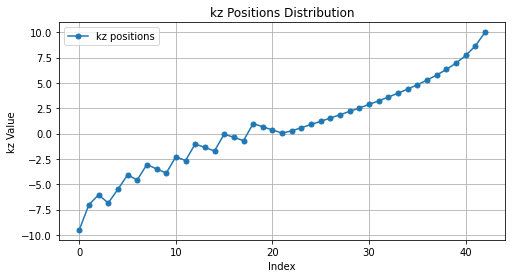

In [2]:
mat_data_4 = loadmat('fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')
csi_data = mat_data_4['csi']
par_data = csi_data['Par'][0,0]
kz_positions = par_data['kzPositions'][0][0][0]

# Plot kz positions
plt.figure(figsize=(8, 4))
plt.plot(kz_positions, 'o-', markersize=5, label='kz positions')
plt.xlabel('Index')
plt.ylabel('kz Value')
plt.title('kz Positions Distribution')
plt.legend()
plt.grid()
plt.show()

**Reconstructing Ring Radii**

Note that there where up to 44 Rings per plane (fixed k_z position)

**CAUTION** There seems to be inconsistent caling

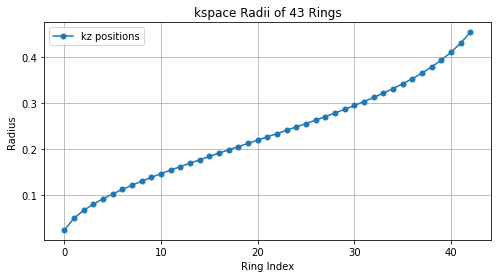

In [3]:
### csi_data = mat_data_3['csi']
par_data = csi_data['Par'][0,0]
kSpaceRadii = par_data['kSpaceRadii'][0][0][0]
#kSpaceRadii = 22*kSpaceRadii/kSpaceRadii[-1]


# Plot kz positions
plt.figure(figsize=(8, 4))
plt.plot(kSpaceRadii, 'o-', markersize=5, label='kz positions')
plt.xlabel('Ring Index')
plt.ylabel('Radius')
plt.title('kspace Radii of 43 Rings')
plt.legend()
plt.grid()
plt.show()

**First k_x, k_y position per Ring**

**Note**: Inconsitent with radii, but the quotient of two corresponding positions is idenditcal to the quotient of to corresponding radii

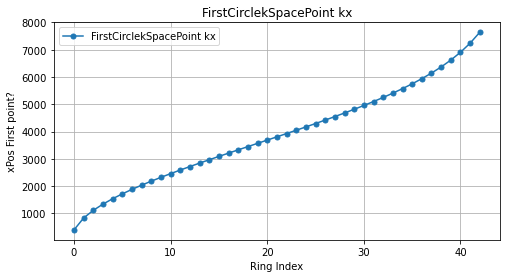

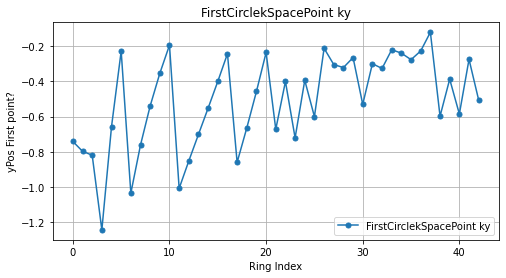

In [4]:
csi_data = mat_data_4['csi']
par_data = csi_data['Par'][0,0]
xPos = par_data['FirstCirclekSpacePoint'][0][0][0]
yPos = par_data['FirstCirclekSpacePoint'][0][0][1]
# yPos = 
# #kSpaceRadii = 22*kSpaceRadii/kSpaceRadii[-1]


# Plot kz positions
plt.figure(figsize=(8, 4))
plt.plot(xPos, 'o-', markersize=5, label='FirstCirclekSpacePoint kx')
plt.xlabel('Ring Index')
plt.ylabel('xPos First point?')
plt.title('FirstCirclekSpacePoint kx')
plt.legend()
plt.grid()
plt.show()

# Plot kz positions
plt.figure(figsize=(8, 4))
plt.plot(yPos, 'o-', markersize=5, label='FirstCirclekSpacePoint ky')
plt.xlabel('Ring Index')
plt.ylabel('yPos First point?')
plt.title('FirstCirclekSpacePoint ky')
plt.legend()
plt.grid()
plt.show()

**Rings per plane**

I extract how many of these 43 rings where actually measured as a function of k_z position

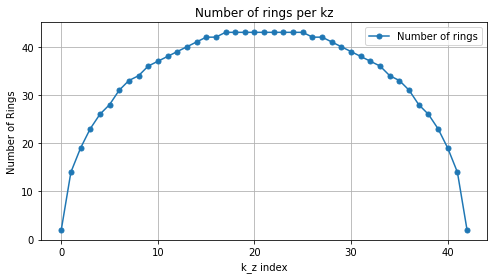

In [5]:
csi_data = mat_data_4['csi']
par_data = csi_data['Par'][0,0]
RingsPerPlane = par_data['AngIntsPerPartEnc'][0][0] # This is a 2D logical matrix of size 43x44, with ones and zeros
RingsPerPlane_summed = np.sum(RingsPerPlane, axis = 1) # compute the some of rings per kz position

# # Plot kz positions
plt.figure(figsize=(8, 4))
plt.plot(RingsPerPlane_summed, 'o-', markersize=5, label='Number of rings')
plt.xlabel('k_z index')
plt.ylabel('Number of Rings')
plt.title('Number of rings per kz')
plt.legend()
plt.grid()
plt.show()

In [8]:
43*43*526

972574

**Number of points per Ring**

Here I extract how many kspace points each ring had (44 rings)

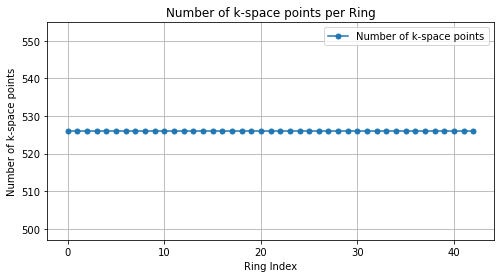

In [6]:
csi_data = mat_data_4['csi']
par_data = csi_data['Par'][0,0]
TrajPoints = par_data['TrajTotPts'][0][0][0] # This is a list of 44 elements, containing the number of points measured for the corresponding ring


# # Plot kz positions
plt.figure(figsize=(8, 4))
plt.plot(TrajPoints, 'o-', markersize=5, label='Number of k-space points')
plt.xlabel('Ring Index')
plt.ylabel('Number of k-space points')
plt.title('Number of k-space points per Ring')
plt.legend()
plt.grid()
plt.show()

**Reconstructing 3D k-space volume**

Here I put the above information together to reconstruct the complete positions that have actually been measured and visualize the result.